In [1]:
import pandas as pd
import numpy as np
from google_play_scraper import reviews_all, Sort
import plotly.express as px


In [2]:
app_reviews = reviews_all(
    'com.depop',
    sort=Sort.NEWEST,
    sleep_milliseconds=0,
    lang='en',
    country='GB'
)


In [3]:
df = pd.json_normalize(app_reviews)
print(df.head())
columns_to_drop = ['reviewId', 'userName','userImage']
df_reviews= df.drop(columns=columns_to_drop)


                               reviewId        userName  \
0  048b5eb6-0ecb-479d-a089-55d0db661cf7  Tiffany Castro   
1  f4466a53-33fb-46a4-9d16-301a664f3cdc       DENNIS TE   
2  2907fa9f-30f8-42ed-a67d-8b91b4b18abf     Mick Knaggs   
3  f2155d53-1bb6-4fc5-bfb3-57a718124eff        skrt69yt   
4  02ddaee2-9265-4e47-8cc1-3c6d898c476a        Liza Lam   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0  It's fun to buy and sell through here. I've be...      5              0   
1  Great place to get to buy clothes, backpacks, ...      5              0   
2                               DARK MODE NEEDED FGS      1              0

In [4]:
import pandas as pd

# Assuming your DataFrame is named 'df_reviews' and the timestamp column is named 'at'

# Convert 'at' to datetime
df_reviews['at'] = pd.to_datetime(df_reviews['at'])

# Create a new column 'date' with only the date part
df_reviews['date'] = df_reviews['at'].dt.date

# Create a new column 'year' with only the year part
df_reviews['year'] = df_reviews['at'].dt.year



# Display the first few rows to verify
print(df_reviews.head())


                                             content  score  thumbsUpCount  \
0  It's fun to buy and sell through here. I've be...      5              0   
1  Great place to get to buy clothes, backpacks, ...      5              0   
2                               DARK MODE NEEDED FGS      1              0   
3                                    such a cool app      5              0   
4  I deactivated the app after 2 weeks. Received ...      1              0   

  reviewCreatedVersion                  at  \
0              2.276.1 2024-02-03 22:34:45   
1              2.276.1 2024-02-03 21:07:50   
2              2.276.1 2024-02-03 18:56:19   
3              2.276.1 2024-02-03 17:19:47   
4                2.276 2024-02-03 13:36:47   

                                        replyContent           repliedAt  \
0                                               None                 NaT   
1  Thank you for your feedback! We are glad to he... 2024-02-04 23:00:20   
2  Thanks for the feedback

CLEAN

In [5]:
# Make sure you've downloaded the necessary NLTK data

import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text, additional_stopwords=[], remove_from_stopwords=[]):
    # Check if text is None
    if text is None:
        return ''
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove emojis with a generalized regex pattern
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"  # dingbats
                           u"\U000024C2-\U0001F251"  # enclosed characters
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Modify stopwords
    stop_words = set(stopwords.words('english'))
    # Add additional stopwords
    stop_words.update(additional_stopwords)
    # Remove certain words from stopwords
    stop_words = stop_words - set(remove_from_stopwords)

    # Filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin filtered tokens into a string
    return ' '.join(filtered_tokens)

# Example usage
# processed_text = preprocess_text("Your text here", additional_stopwords=['app'], remove_from_stopwords=['not'])

# # Apply the preprocessing function to each review
# df_reviews['cleaned_review_text'] = df_reviews['content'].apply(preprocess_text)
# # Assuming df_reviews is your DataFrame and 'content' is the column with review texts

# Define additional stopwords and stopwords to remove
additional_stopwords = ['ive', 'depop', 'item','dont','cant','people','im','anything','great','get','even','like','items','app']  # Add more words as needed
remove_from_stopwords = []  # Add more words as needed

# Apply the preprocessing function with additional arguments
df_reviews['cleaned_review_text'] = df_reviews['content'].apply(lambda x: preprocess_text(x, additional_stopwords, remove_from_stopwords))


In [6]:
import pandas as pd

# Assuming df_reviews is your main DataFrame and it has a 'year' column

# Define the bad years (negative years as per your context)
growth_years = [2016,2017,2018]

# Filter the DataFrame to include only the rows with years that are in the bad_years list
df_growth_years = df_reviews[df_reviews['year'].isin(growth_years)]

# You can now work with df_negative_years for further analysis.


Taking only the reviews of rating 3 or less than 3 - Cause that will help us identify the problem

In [8]:
#low_score_reviews = df_negative_years[df_negative_years['score'] <= 3]
high_score_reviews = df_growth_years[df_growth_years['score'] > 3]


Applying LDA

In [9]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'low_score_reviews' is your DataFrame and 'cleaned_review_text' is the column with text data.

# Step 1: Tokenize the cleaned reviews
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(high_score_reviews['cleaned_review_text'])

# Step 2: Convert sparse matrix to gensim corpus
corpus = gensim.matutils.Sparse2Corpus(data_vectorized, documents_columns=False)

# Step 3: Mapping from word IDs to words (to see the actual words)
id_map = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Step 4: LDA model
ldamodel = LdaModel(corpus=corpus, id2word=id_map, num_topics=8, passes=25, random_state=34)

# Step 5: Print the topics
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.058*"better" + 0.049*"ebay" + 0.039*"make" + 0.028*"way" + 0.028*"looking" + 0.027*"sale" + 0.026*"wish" + 0.025*"money" + 0.022*"recommend" + 0.019*"let"')
(1, '0.024*"sellers" + 0.019*"messages" + 0.019*"really" + 0.017*"seller" + 0.016*"friendly" + 0.015*"things" + 0.013*"update" + 0.013*"time" + 0.013*"user" + 0.011*"fix"')
(2, '0.380*"love" + 0.077*"amazing" + 0.057*"awesome" + 0.025*"shopping" + 0.022*"absolutely" + 0.022*"brilliant" + 0.020*"deals" + 0.016*"things" + 0.015*"bought" + 0.013*"favorite"')
(3, '0.040*"page" + 0.032*"lot" + 0.024*"option" + 0.021*"wish" + 0.020*"options" + 0.018*"search" + 0.018*"excellent" + 0.018*"stuff" + 0.016*"got" + 0.016*"explore"')
(4, '0.248*"easy" + 0.183*"use" + 0.047*"fun" + 0.041*"super" + 0.030*"simple" + 0.018*"really" + 0.016*"quick" + 0.015*"nice" + 0.015*"community" + 0.012*"quality"')
(5, '0.123*"sell" + 0.122*"buy" + 0.066*"way" + 0.049*"clothes" + 0.031*"things" + 0.030*"stuff" + 0.026*"place" + 0.022*"shop" + 0.018*"want"

In [11]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Use your existing 'low_score_reviews' DataFrame and 'cleaned_review_text' column for this code.

# Step 1: Tokenize the cleaned reviews
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(high_score_reviews['cleaned_review_text'])

# Step 2: Convert sparse matrix to gensim corpus
corpus = gensim.matutils.Sparse2Corpus(data_vectorized, documents_columns=False)

# Step 3: Mapping from word IDs to words (to see the actual words)
id_map = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Step 4: LDA model
ldamodel = LdaModel(corpus=corpus, id2word=id_map, num_topics=4, passes=25, random_state=34)

# Step 5: Visualize the topics using pyLDAvis
# Convert the Gensim corpus and dictionary to the format pyLDAvis expects
# Note: This step can take some time depending on the size of your corpus and the complexity of the model
vis_data = gensimvis.prepare(ldamodel, corpus, dictionary=corpora.Dictionary.from_corpus(corpus, id_map))

# Step 6: Display the visualization
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)


<>:11: DeprecationWarning: invalid escape sequence \-
<>:11: DeprecationWarning: invalid escape sequence \-
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23464\1874148849.py:11: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


In [34]:
from nrclex import NRCLex
import pandas as pd

# Function to get emotions from a text
def get_emotions(text):
    # Create a NRCLex object
    text_object = NRCLex(text)
    
    # Return the top emotion
    top_emotion = text_object.top_emotions[0]
    return top_emotion

# Apply the function to your DataFrame
low_score_reviews['top_emotion'] = low_score_reviews['cleaned_review_text'].apply(lambda x: get_emotions(x))

# Viewing the DataFrame with the top emotions
print(low_score_reviews[['cleaned_review_text', 'top_emotion']].head())


                                  cleaned_review_text  \
1   december asked refund still aint got anything ...   
4   like depop service experience awful bombarded ...   
6   glitchy creating sales posts despite recent up...   
15  filter size still show mostly sxs makes hard s...   
16  impossible edit listing change shipping addres...   

                       top_emotion  
1                  (negative, 1.0)  
4                    (anger, 0.15)  
6   (negative, 0.3333333333333333)  
15                    (trust, 1.0)  
16                    (fear, 0.25)  


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21456\3900237578.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_score_reviews['top_emotion'] = low_score_reviews['cleaned_review_text'].apply(lambda x: get_emotions(x))


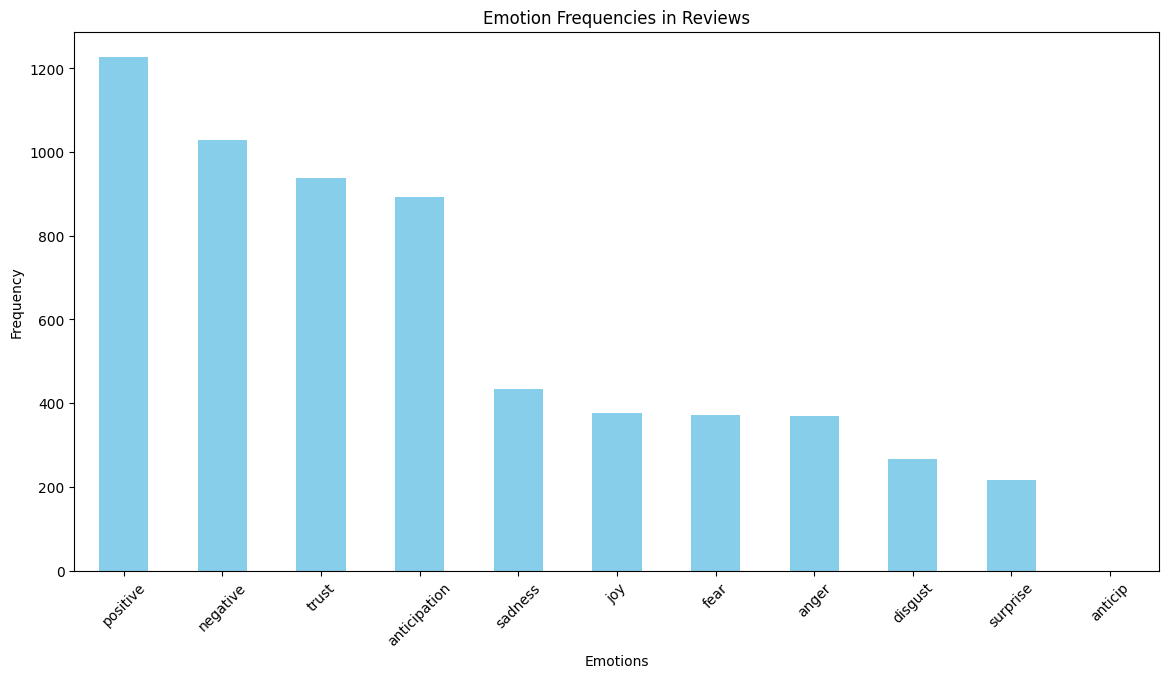

In [35]:
import pandas as pd
from nrclex import NRCLex
import matplotlib.pyplot as plt
from collections import defaultdict

# Assuming low_score_reviews['cleaned_review_text'] is your DataFrame's column with cleaned text

# Function to get emotion frequencies from a text
def get_emotion_frequencies(text):
    text_object = NRCLex(text)
    return text_object.affect_frequencies

# Apply the function to each review and create a new DataFrame with the emotions
emotion_df = low_score_reviews['cleaned_review_text'].apply(get_emotion_frequencies).apply(pd.Series)

# Sum up the emotion frequencies for all reviews
emotion_totals = emotion_df.sum().sort_values(ascending=False)

# Plotting the emotion frequencies
plt.figure(figsize=(14, 7))
emotion_totals.plot(kind='bar', color='skyblue')
plt.title('Emotion Frequencies in Reviews')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


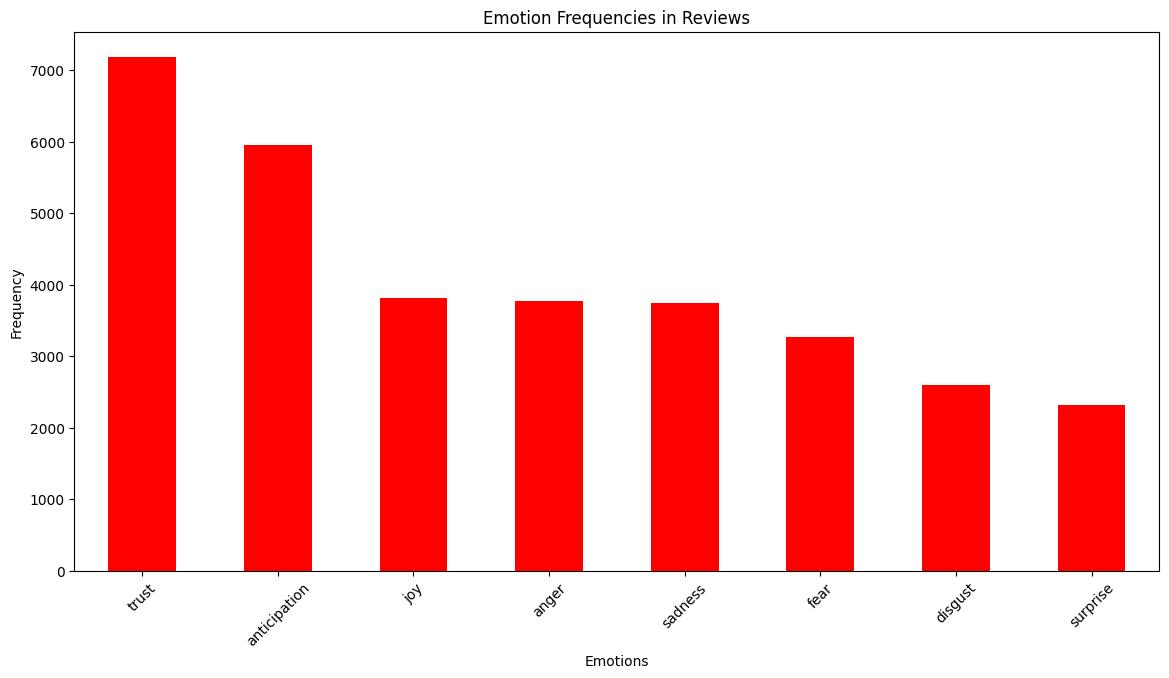

In [38]:
import pandas as pd
from nrclex import NRCLex
import matplotlib.pyplot as plt

# Assuming low_score_reviews['cleaned_review_text'] is your DataFrame's column with cleaned text

# Function to get emotion frequencies from a text
def get_emotion_frequencies(text):
    text_object = NRCLex(text)
    # Get the raw emotion scores
    emotion_freqs = text_object.raw_emotion_scores
    # Exclude 'positive' and 'negative' sentiments if present
    emotion_freqs.pop('positive', None)
    emotion_freqs.pop('negative', None)
    return emotion_freqs

# Apply the function to each review
emotion_freqs_list = low_score_reviews['cleaned_review_text'].apply(get_emotion_frequencies)

# Create a DataFrame from the list of emotion frequency dictionaries
emotion_df = pd.DataFrame(emotion_freqs_list.tolist())

# Sum up the emotion frequencies for all reviews
emotion_totals = emotion_df.sum().sort_values(ascending=False)

# Plotting the emotion frequencies
plt.figure(figsize=(14, 7))
emotion_totals.plot(kind='bar', color='red')
plt.title('Emotion Frequencies in Reviews')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
